In [1]:
import numpy as np
from pymanopt.manifolds import Sphere
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

import mala.utils as my
import mala.potentials
import mala.metropolis_hastings as vanilla_mh
import mala.MA_metropolis_hastings as mamh
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [2]:
M = Sphere(3)
data = list()
N = 1000
for _ in range(N):
    data.append(M.rand())

In [3]:
H = mala.potentials.Spherical(ambient_dim=3,proper_dim=2)

# Visualize our potential over the sphere

You can click and drag to look around the sphere

In [4]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
vals=[H.eval(x) for x in data]
grads = [H.gradient(x) for x in data]
data = np.asarray(data)

ax.scatter(data[:,0],data[:,1], data[:,2], c=vals)

# randomly subsample some points and visualize their gradients
for ii in range(500):
    x = data[ii,:]
    grad_x = grads[ii]
    ax.quiver(x[0],x[1],x[2],grad_x[0],grad_x[1],grad_x[2],
              length=0.2, normalize=True,color='r')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# plot sphere surface to occlude opposite side
u = np.linspace(0, 2 * np.pi, 13)
v = np.linspace(0, np.pi, 7)

x = .9 * np.outer(np.cos(u), np.sin(v))
y = .9* np.outer(np.sin(u), np.sin(v))
z = .9 * np.outer(np.ones(np.size(u)), np.cos(v))

# use scipy to interpolate
xdata = scipy.ndimage.zoom(x, 3)
ydata = scipy.ndimage.zoom(y, 3)
zdata = scipy.ndimage.zoom(z, 3)

ax.plot_surface(xdata, ydata, zdata, rstride=3, cstride=3, color='w', shade=0,alpha=0.8)
# plot sphere surface

plt.show()


<IPython.core.display.Javascript object>

# Euclidean and Riemannian gradients

In [5]:
x = data[0]
print(H.gradient(x))
print(M.proj(x,M.egrad2rgrad(x,H.gradient(x))))

[-1.89012673 -1.98006861 -0.48896057]
[-1.89012673 -1.98006861 -0.48896057]


# Sampling over our sphere

Manifold-Adjusted MALA, Fisher matrix


<IPython.core.display.Javascript object>


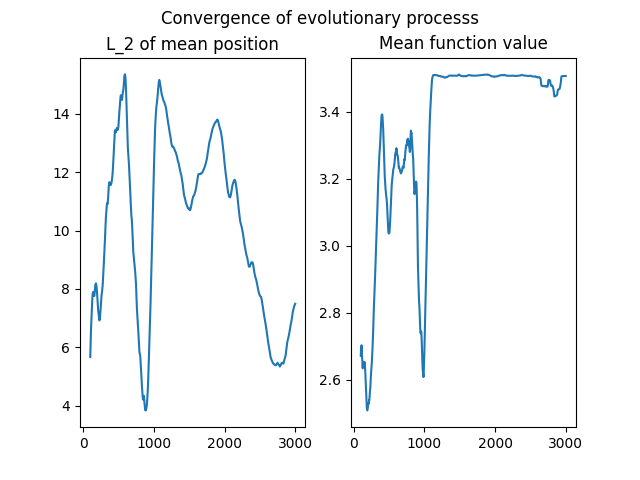

<IPython.core.display.Javascript object>


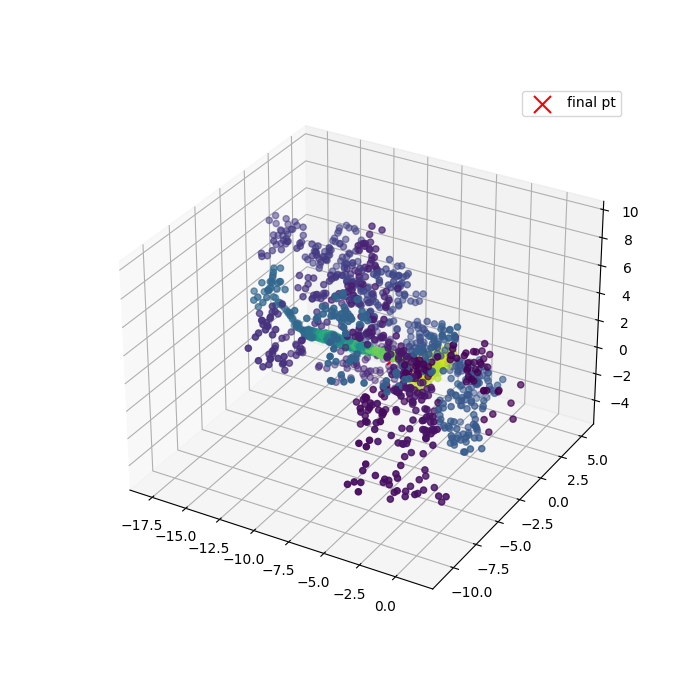

<IPython.core.display.Javascript object>


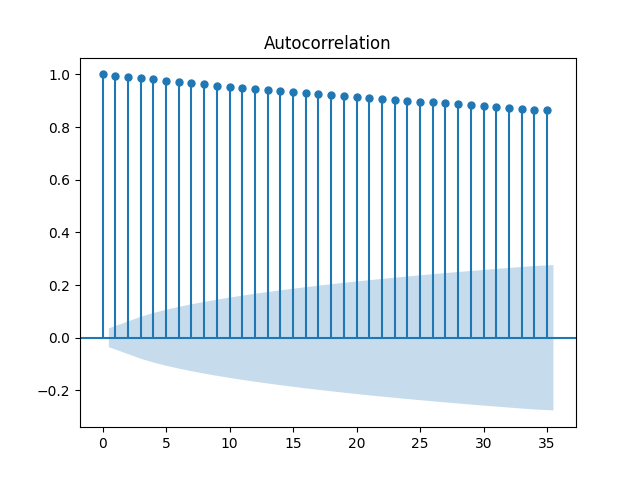

Manifold-Adjusted MALA, sphere metric


<IPython.core.display.Javascript object>


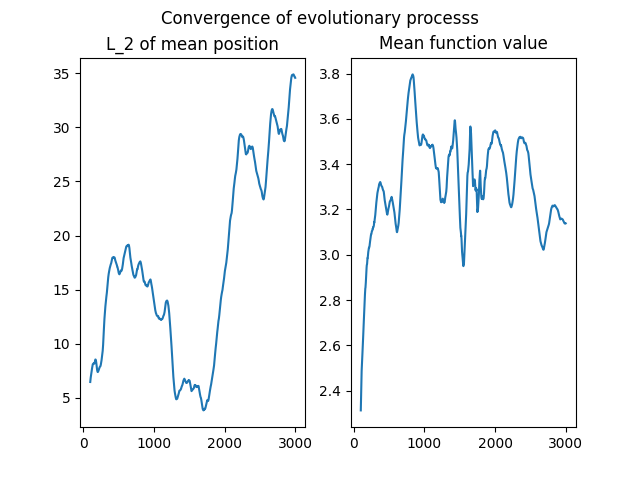

<IPython.core.display.Javascript object>


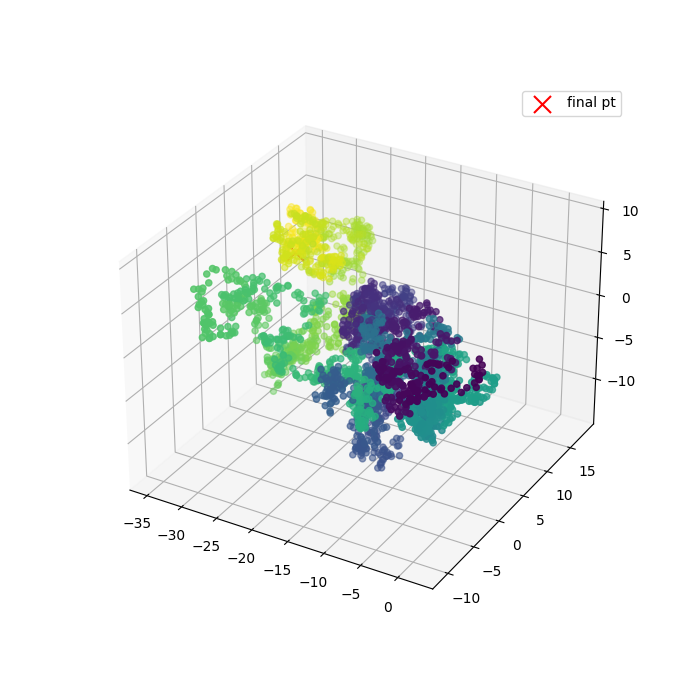

<IPython.core.display.Javascript object>


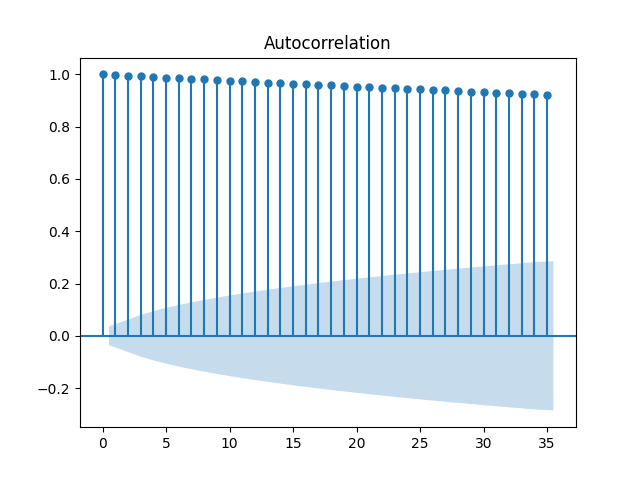

Vanilla MALA


<IPython.core.display.Javascript object>


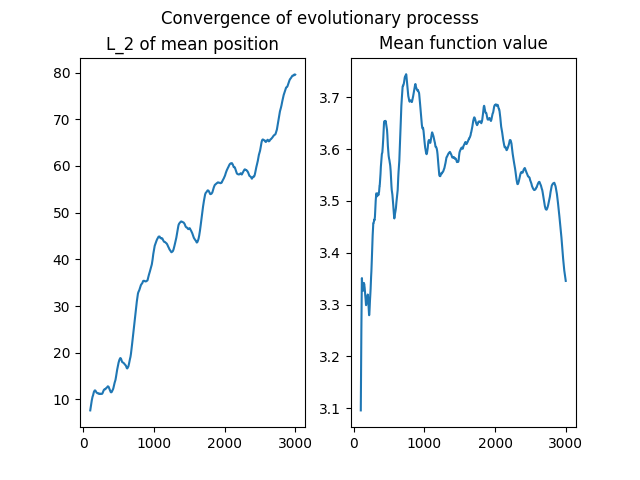

<IPython.core.display.Javascript object>


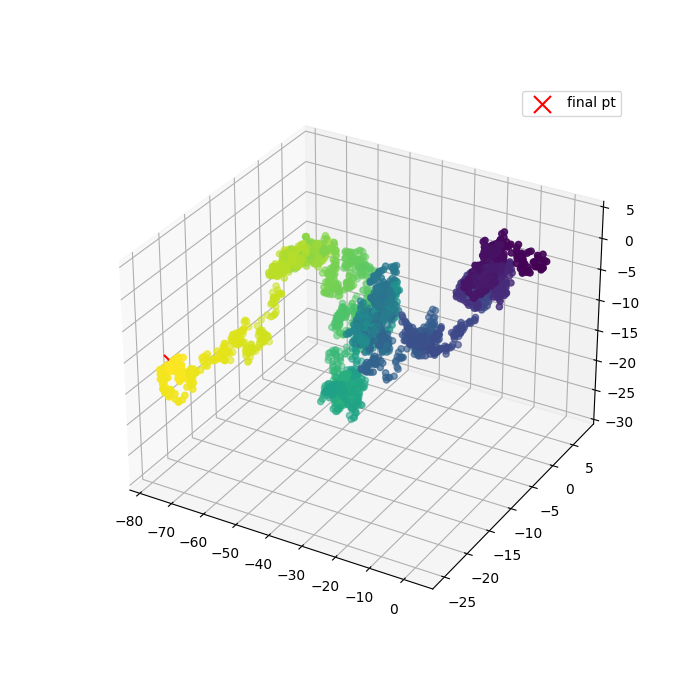

<IPython.core.display.Javascript object>


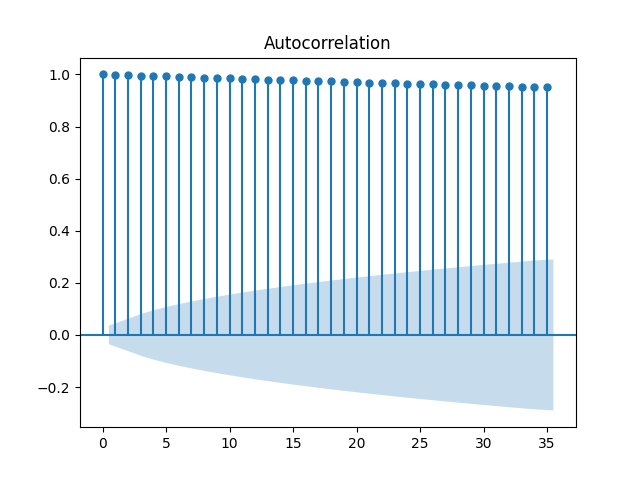

Gaussian


<IPython.core.display.Javascript object>


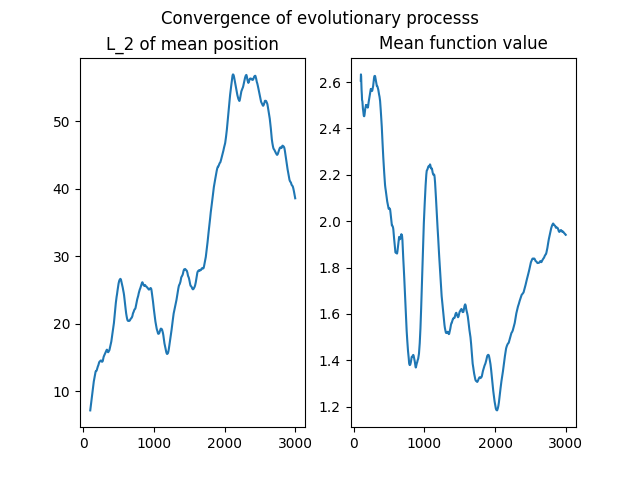

<IPython.core.display.Javascript object>


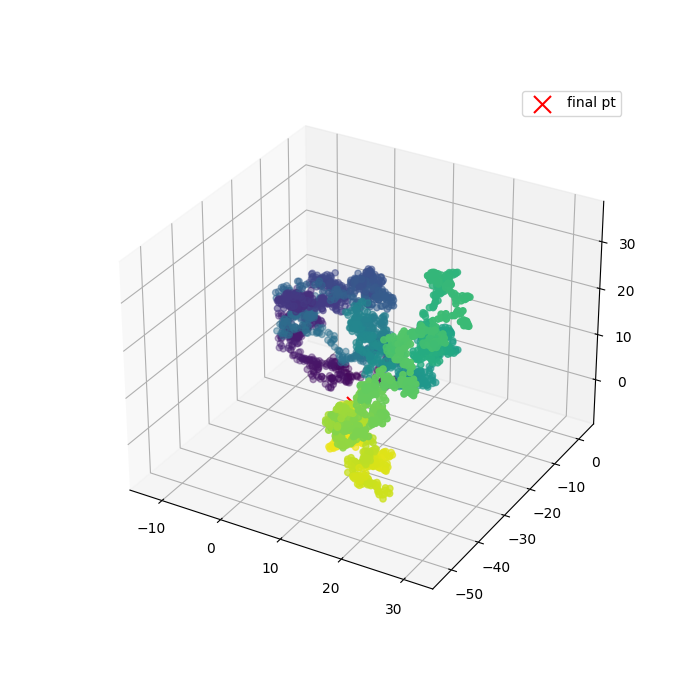

<IPython.core.display.Javascript object>


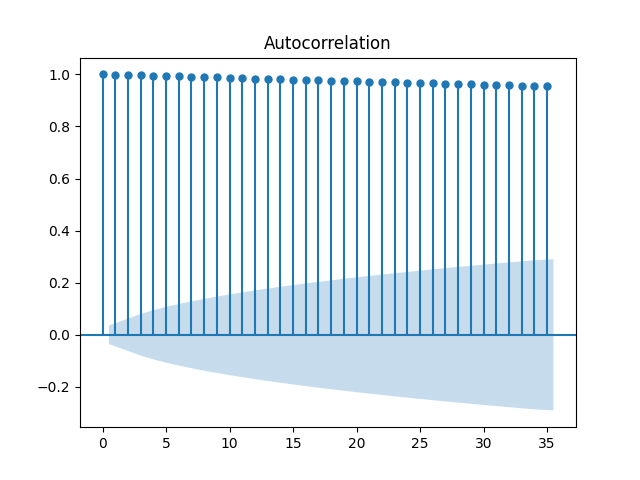

In [12]:
# Initialize randomly (on unit sphere WLOG)
x_0 = np.random.normal(loc=0,scale=1,size=3)
x_0 = np.divide(x_0,np.linalg.norm(x_0,ord=2))
T = 3000
burnin = 1000
step_size = 0.5

# Use the observed Fisher information matrix as an approximation of the 
# Fisher-Rao metric
print('Manifold-Adjusted MALA, Fisher matrix')
info_matrix = (lambda x,traj : mamh.empirical_Fisher_metric(H,x,traj, burnin))
evolution = mamh.MAMH(_,H,
                 update_rule=(lambda x,traj: mamh.const_K_langevin(x,traj,info_matrix,H,step_size)),
                     initial_point=x_0,max_steps=T)
my.mean_convergence(H,evolution)
my.plot_3D_evolution(H,evolution)

plot_acf(np.array([v.pos[0] for v in evolution]))
plt.show()

print('Manifold-Adjusted MALA, sphere metric')
sphere_metric = (lambda x,_ : mamh.metric_tensor(M,x))
evolution = mamh.MAMH(_,H,
                 update_rule=(lambda x,traj: mamh.const_K_langevin(x,traj,sphere_metric,H,step_size)),
                     initial_point=x_0,max_steps=T)
my.mean_convergence(H,evolution)
my.plot_3D_evolution(H,evolution)

plot_acf(np.array([v.pos[0] for v in evolution]))
plt.show()

print('Vanilla MALA')
identity_matrix = (lambda x,_ : np.identity(x.size))
evolution = mamh.MAMH(_,H,
                 update_rule=(lambda x,traj: mamh.const_K_langevin(x,traj,identity_matrix,H,step_size)),
                     initial_point=x_0,max_steps=T)
my.mean_convergence(H,evolution)
my.plot_3D_evolution(H,evolution)

plot_acf(np.array([v.pos[0] for v in evolution]))
plt.show()

print('Gaussian')
evolution = mamh.MAMH(_,H,
                 update_rule=(lambda x,_: vanilla_mh.gaussian(_,x,radius=step_size)),
                     initial_point=x_0,max_steps=T)
my.mean_convergence(H,evolution)
my.plot_3D_evolution(H,evolution)

plot_acf(np.array([v.pos[0] for v in evolution]))
plt.show()



# Estimating true integral via naive monte carlo

In [13]:
def f_spherical(theta,phi):
    return np.sqrt(np.power(theta,2)+np.power(phi,2))*np.sin(phi)

sample_num = 10000
theta_vals = np.random.uniform(low = 0, high = 2*np.pi, size = sample_num)
phi_vals =np.random.uniform(low = 0, high = np.pi, size = sample_num)

np.mean([f_spherical(theta_vals[ii],phi_vals[ii]) for ii in range(sample_num)])


2.3588681359566466